<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

In [48]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import threading
import warnings
import sweetviz as sv
warnings.filterwarnings('ignore', category=Warning)

In [49]:
print(tf.__version__)
print(tf.test.is_gpu_available())
print(tf.config.list_physical_devices('GPU'))

2.19.0
False
[]


E0000 00:00:1747469551.959642   13969 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1747469551.973793   13969 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [51]:
data_list = []
for i in range(30):
    df = pd.read_csv(f'../../data/data_EEG/s{i:02d}.csv', header=None)
    data_list.append(df.transpose().to_numpy())

In [52]:
df_view = pd.read_csv(f'../../data/data_EEG/s{i:02d}.csv', header=None)
df_view

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,2.891400,10.145000,6.202000,6.598600,3.888400,8.634200,-2.845800,4.390900,0.271170,5.505600,-3.340900,4.68650,-0.840570,0.990550,-5.770500,4.099100,6.593500,1.990200,2.55470
1,3.708100,9.836600,6.379900,6.819400,3.122600,10.591000,-3.103300,3.943500,0.713470,5.543400,-3.223100,3.43950,-0.954640,0.192880,-6.142000,2.980500,7.797800,2.454400,2.06070
2,4.545400,9.129800,6.417100,6.821800,2.326300,11.944000,-3.264900,3.243400,1.143900,5.464800,-3.026700,2.03800,-0.823240,-0.770730,-6.195100,1.518900,8.720100,2.770800,1.54080
3,5.299100,8.049500,6.251100,6.517900,1.650900,12.149000,-3.154700,2.335000,1.500400,5.243000,-2.739800,0.69305,-0.364070,-1.762300,-5.763200,-0.138650,9.027100,2.817400,1.12310
4,5.849800,6.747400,5.838300,5.887800,1.131700,10.928000,-2.626700,1.308200,1.754900,4.898700,-2.336000,-0.38428,0.453200,-2.612000,-4.765800,-1.774900,8.521700,2.554000,0.94627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30995,-0.000832,-0.000063,-0.000388,-0.000738,-0.000007,0.000735,-0.001014,0.000179,0.000466,-0.001172,0.000815,0.00058,0.001246,0.000955,0.001659,0.001965,-0.000974,-0.001453,0.00168
30996,-0.000832,-0.000063,-0.000388,-0.000738,-0.000007,0.000735,-0.001014,0.000179,0.000466,-0.001172,0.000815,0.00058,0.001246,0.000955,0.001659,0.001965,-0.000974,-0.001453,0.00168
30997,-0.000832,-0.000063,-0.000388,-0.000738,-0.000007,0.000735,-0.001014,0.000179,0.000466,-0.001172,0.000815,0.00058,0.001246,0.000955,0.001659,0.001965,-0.000974,-0.001453,0.00168
30998,-0.000832,-0.000063,-0.000388,-0.000738,-0.000007,0.000735,-0.001014,0.000179,0.000466,-0.001172,0.000815,0.00058,0.001246,0.000955,0.001659,0.001965,-0.000974,-0.001453,0.00168


In [53]:
df_view.isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
dtype: int64

In [55]:
df_view.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,31000.000000,31000.000000,31000.000000,31000.000000,31000.000000,31000.000000,31000.000000,31000.000000,31000.000000,31000.000000,31000.000000,31000.000000,31000.000000,31000.000000,31000.000000,31000.000000,31000.000000,31000.000000,31000.000000
mean,-0.102985,-0.115753,-0.124731,-0.088528,-0.228462,-0.000157,-0.078687,0.094896,0.006163,-0.023736,0.086305,0.119694,0.095635,0.254868,0.144249,0.140977,-0.073141,-0.024716,0.116252
std,10.287185,9.884744,10.824912,9.807620,9.381542,9.879764,9.736192,8.497041,11.132940,11.327990,8.035824,11.379396,14.137969,16.193756,18.488541,21.461871,10.227690,12.061418,15.959239
min,-38.578000,-49.347000,-48.552000,-43.191000,-61.686000,-42.388000,-42.797000,-31.862000,-47.655000,-52.014000,-26.634000,-40.796000,-44.035000,-51.914000,-57.026000,-65.715000,-43.086000,-53.159000,-51.954000
25%,-6.594300,-6.114050,-6.887175,-6.476000,-6.107500,-5.903800,-6.071700,-5.559875,-7.091825,-7.402800,-5.339025,-7.843125,-9.629800,-11.081000,-13.132500,-15.474000,-6.573300,-7.744800,-11.027750
50%,-0.000832,-0.000063,-0.000388,-0.013142,-0.000007,0.261250,-0.001014,0.000179,0.182410,-0.001958,0.009037,0.000580,-0.174910,-0.059021,0.001659,-0.168480,-0.000974,-0.001453,-0.214970
75%,6.916300,6.363675,7.180400,6.587400,6.023200,6.345600,6.174100,5.494200,7.386775,7.446875,5.400500,7.240750,9.093700,11.674000,12.268000,14.732500,6.628725,7.888500,10.555500
max,32.594000,40.952000,38.450000,38.103000,38.679000,42.976000,35.667000,42.741000,49.286000,51.037000,33.235000,49.604000,50.594000,79.103000,62.910000,73.909000,38.701000,52.101000,61.631000


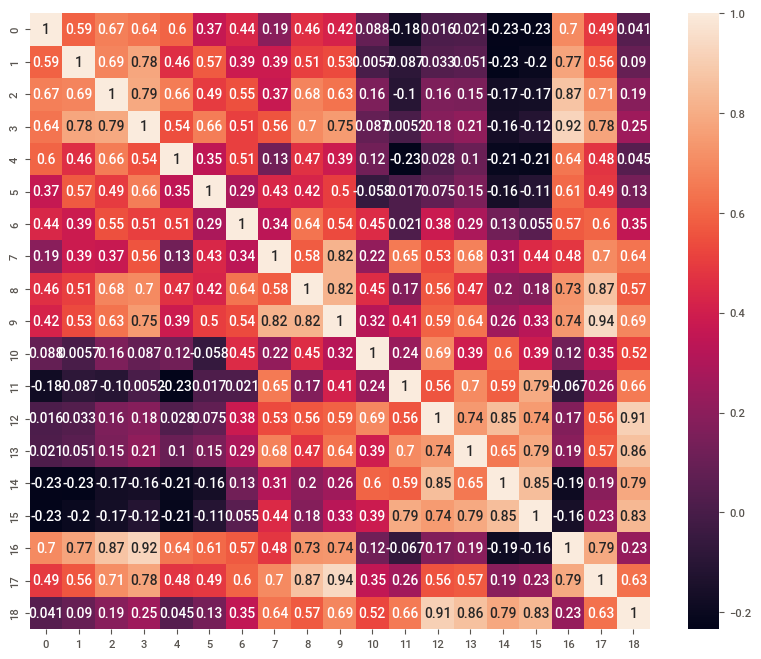

In [56]:
import seaborn  as sns 
corr_matrix = df_view.corr()
    
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [4]:
dataset_X = np.array(data_list)
dataset_X.shape

(30, 19, 31000)

In [5]:
dataset_X = dataset_X.reshape(30, 760, 775, 1).astype('float32')

# Leave-One-Out Cross-Validation (LOOCV) Explained

	Notice how rows 30-35 are excluded from the initial processing (like transpose and to_numpy) - these are reserved as the test set, not for validation!

	This method called Leave-One-Out Cross-Validation (LOOCV), is particularly valuable for EEG and other neuroimaging data because:

	Personalization Matters: Each participant has unique baseline brain activity, signal amplitudes, and response patterns

	Maximized Data Utility: With typical EEG studies having just 20-40 participants, LOOCV gives the most statistically reliable results

In [6]:
y = np.array([0,1,1,1,0,1,0,1,1,0,0,1,1,1,0,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1])
y = y.reshape(-1, 1)
y.shape

(30, 1)

In [7]:
import tensorflow as tf
print(tf.__version__)
a = tf.constant([1.0, 2.0])
b = tf.constant([3.0, 4.0])
c = a + b
print(c)

2.19.0
tf.Tensor([4. 6.], shape=(2,), dtype=float32)


In [8]:
seed = 42
tf.random.set_seed(seed)

# Model Building


# Early Stop:

	We introduced early stop here: early stop is a technique used to prevent overfitting. Patience=5 means with 5 consecutive 0 or negative improvement, we will stop trainning and return the best model.

# LSTM:

	The change I made is LSTM (Long-Short Term Memory), which is a special type of RNN that 'forgets' but not only 'remembers'. LSTM is useful for EEG data, since after one math task, the brain state data should approximated be set back to the baseline. This means forgetting is suitable for experiments with multiple discrete tasks.

# Convolutional Layers for Feature Extraction:

	I kept this part from the orgininal notebook. It uses Conv2D with 16 filters and strides of 2 to process the EEG's spatial dimensions, followed by max pooling and batch normalization to stabilize activations.

A 20% dropout layer helps prevent overfitting to electrode-specific noise. These layers extract localized spatial patterns from the raw input before reshaping for LSTM processing, preserving the critical spatial relationships between electrodes while reducing dimensionality.

The combination of strided convolutions and pooling ensures the network focuses on the most salient neural activity patterns. =) (why am I explaining this its father should have done the work!)

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Build the model
model = tf.keras.models.Sequential([
    # Convolutional layers for feature extraction
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=(2,2), activation='relu',
                           input_shape=(760, 775, 1), padding='same'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    # Reshape to fit LSTM input format
    tf.keras.layers.Reshape((190, -1)),  # Adjusted based on Conv2D+MaxPool2D output

    # LSTM for sequence modeling
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),

    # Fully connected output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), tf.keras.metrics.Precision()])

# Show model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 380, 388, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 190, 194, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 190, 194, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 190, 194, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 190, 3104)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 190, 64)        │       811,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 823,937 (3.14 MB)

 Trainable params: 823,905 (3.14 MB)

 Non-trainable params: 32 (128.00 B)

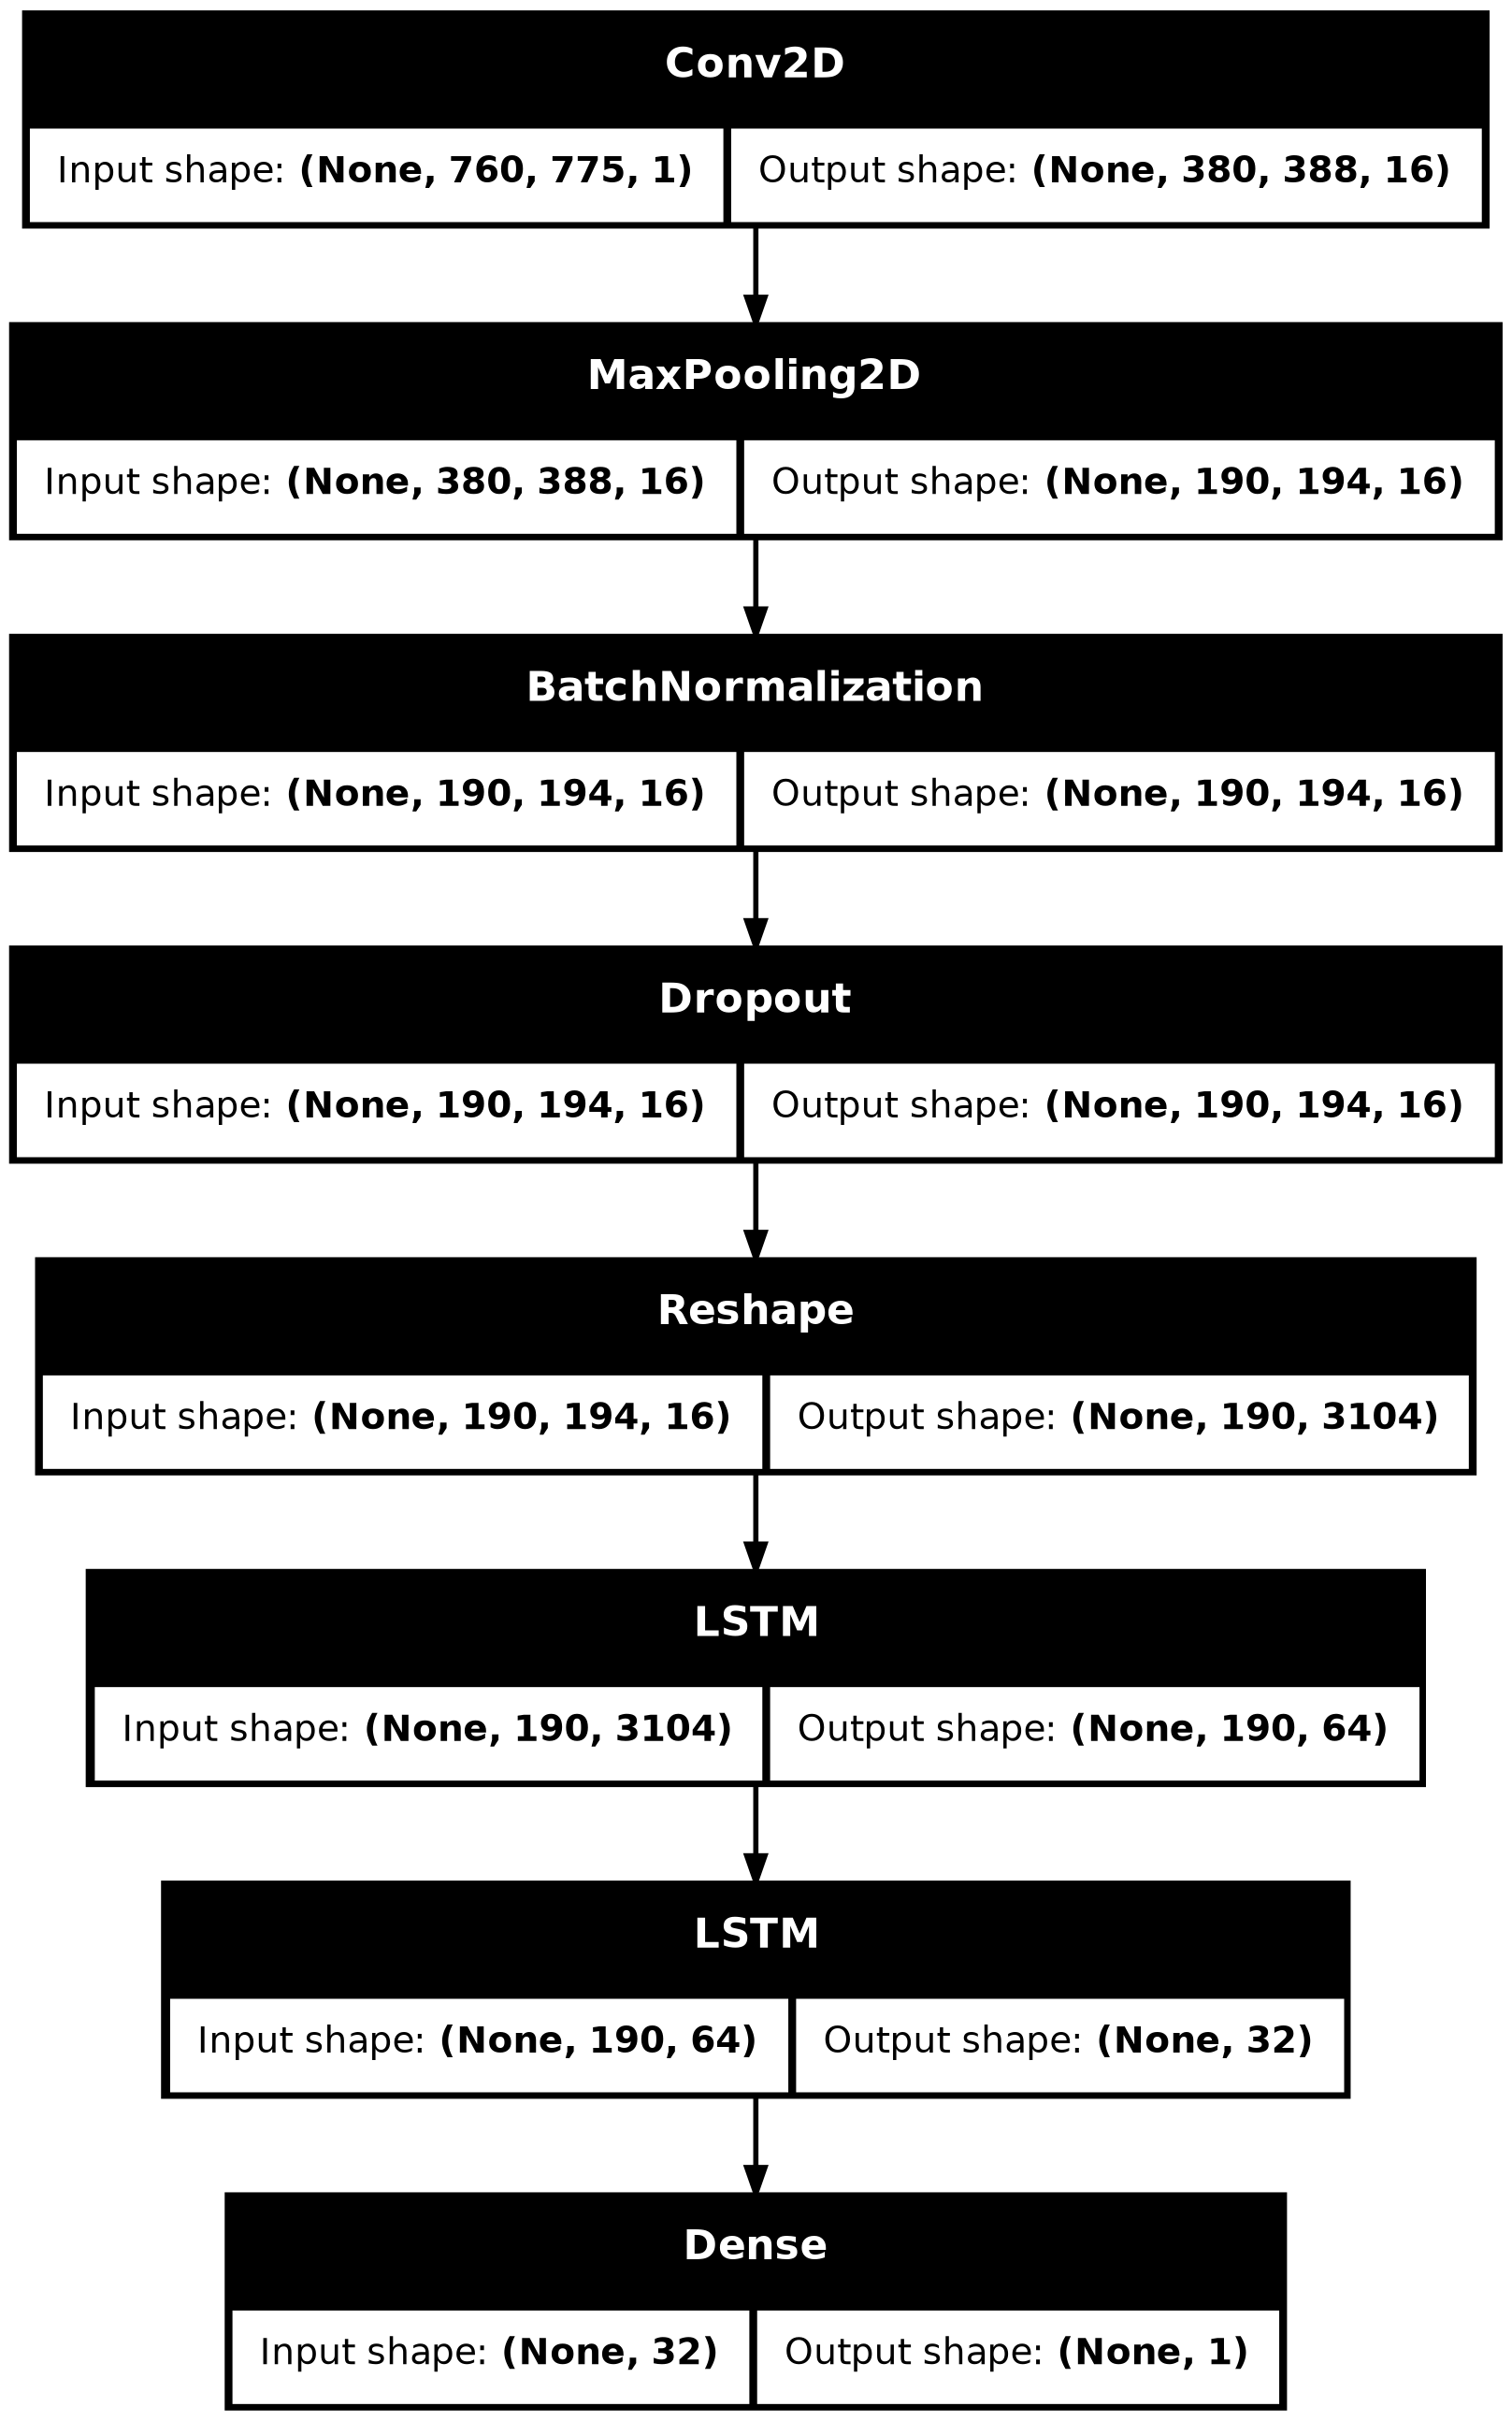

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file='model.png')


In [11]:
model.fit(dataset_X, y, batch_size=1, epochs=25, validation_split=0.25, callbacks=[early_stopping])

Epoch 1/25


2025-05-17 06:26:29.762640: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51832000 exceeds 10% of free system memory.


22/22 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.4495 - auc: 0.4479 - loss: 0.6782 - precision: 0.5877 - recall: 0.6009 - val_accuracy: 0.1250 - val_auc: 0.0714 - val_loss: 0.9450 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 1.0000 - auc: 0.9130 - loss: 0.2167 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.8750 - val_auc: 0.1429 - val_loss: 0.5857 - val_precision: 0.8750 - val_recall: 1.0000
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 1.0000 - auc: 0.9130 - loss: 0.0825 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.8750 - val_auc: 0.1429 - val_loss: 0.5718 - val_precision: 0.8750 - val_recall: 1.0000
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 1.0000 - auc: 0.9130 - loss: 0.0394 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.8750 - val_auc: 0.1429 - val_loss: 0.5649 - val_precision: 0.8750 - val_recall: 1.0000
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2

In [12]:
loss,acc,rec,auc,per=model.evaluate(dataset_X, y ,batch_size=1)

2025-05-17 06:34:55.063391: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 70680000 exceeds 10% of free system memory.


30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 398ms/step - accuracy: 0.9891 - auc: 0.9626 - loss: 0.1602 - precision: 0.9521 - recall: 0.9677


In [13]:
f1 = 2*(per*rec)/(per+rec)

In [14]:
print(f'This is a precision {per}')
print(f'This is a accuracy {acc}')
print(f'This is a recall {rec}')

print(f'This is a f1 score {f1}')

This is a precision 0.9545454382896423
This is a accuracy 0.9666666388511658
This is a recall 1.0
This is a f1 score 0.9767441775361675


In [15]:
data_list_test = []
for i in range(30,36):
    df = pd.read_csv(f'../../data/data_EEG/s{i:02d}.csv', header=None)
    data_list_test.append(df.transpose().to_numpy())

In [16]:
dataset_y = np.array(data_list_test)

In [17]:
dataset_y.shape


(6, 19, 31000)

In [18]:
dataset_y = dataset_y.reshape(6, 760, 775, 1).astype('float32')

In [19]:
y_tets = np.array([0, 1, 1, 1, 0, 1])
y_tets = y_tets.reshape(-1, 1)
y_tets.shape

(6, 1)

In [20]:
model.fit(dataset_y, y_tets, batch_size=1, epochs=25, validation_split=0.25, callbacks=[early_stopping])

Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.8333 - auc: 0.6000 - loss: 0.3531 - precision: 0.8333 - recall: 1.0000 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 1.0125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 1.0000 - auc: 0.6000 - loss: 0.0395 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 1.0702 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 1.0000 - auc: 0.6000 - loss: 0.0322 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 1.2312 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 1.0000 - auc: 0.6000 - loss: 0.0302 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 1.3852 - val_precision: 0.0000e+00 - val_recal

In [21]:
loss_test,acc_test,rec_test,auc_test,per_test=model.evaluate(dataset_y, y_tets ,batch_size=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 406ms/step - accuracy: 0.8762 - auc: 0.8214 - loss: 0.2214 - precision: 0.7500 - recall: 0.7857       


In [22]:
f1_tets = 2*(per_test*rec_test)/(per_test+rec_test)

In [23]:
print(f'This is a precision {per_test}')
print(f'This is a accuracy {acc_test}')
print(f'This is a recall {rec_test}')

print(f'This is a f1 score {f1_tets}')

This is a precision 0.75
This is a accuracy 0.6666666865348816
This is a recall 0.75
This is a f1 score 0.75


In [24]:
dataset_all_ = []
for i in range(1,36):
    df = pd.read_csv(f'../../data/data_EEG/s{i:02d}.csv', header=None)
    dataset_all_.append(df.transpose().to_numpy())

In [25]:
dataset_all = np.array(dataset_all_)


In [26]:
dummy = np.zeros((1, 19, 31000), dtype=dataset_all.dtype)
dataset_all = np.concatenate([dataset_all, dummy], axis=0)
dataset_all = dataset_all.reshape(36, 1, 19, 31000)


In [27]:
dataset_all.shape

(36, 1, 19, 31000)

In [28]:


# Function that seperates two gorups' EEG -- it's okay! 15+ participants each is not a small number
def plot_eeg_group_difference(X, y):
    # Separate EEG data into two groups based on math performance
    X_good = X[y == 1]  # Good math performers
    X_bad = X[y == 0]   # Bad math performers
    
    # Compute the average EEG signal over all channels and subjects for each group
    mean_good = np.mean(X_good, axis=(0, 2))  # Averaged over subjects & channels
    mean_bad = np.mean(X_bad, axis=(0, 2))
    
    # Time axis (assuming time_steps exist)
    time = np.arange(mean_good.shape[0])
    
    # Plot the EEG signal for both groups
    plt.figure(figsize=(10, 5))
    plt.plot(time, mean_good, label='Good Math Performers (y=1)', color='blue')
    plt.plot(time, mean_bad, label='Bad Math Performers (y=0)', color='red', linestyle='dashed')
    
    plt.xlabel('Time Steps')
    plt.ylabel('Mean EEG Signal')
    plt.title('EEG Signal Differences: Good vs. Bad Math Performers')
    plt.legend()
    plt.grid(True)
    plt.show()



In [29]:
y_all=np.array([0,1,1,1,0,1,0,1,1,0,0 ,1 ,1 ,1 ,0 ,1 ,1 ,1 ,1 ,0 ,1 ,0 ,0 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,0 ,1 ,1 ,1 ,1 ,1 ])
y_all=np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35])


In [30]:


factor = 20

# Downsample EEG: average every `factor` time steps
def downsample_eeg(data, factor=20):
    num_subjects, num_channels, num_electrodes, num_time_steps = data.shape

    new_time_steps = num_time_steps // factor
    data = data[:, :, :, :new_time_steps * factor]# Trim excess
    
    #Reshape and average
    data = data.reshape(num_subjects, num_channels, num_electrodes, new_time_steps, factor)
    data = np.mean(data, axis=-1)  #Take mean over last axis(time factor)

    return data



In [34]:
# Downsample EEG data (31000 → 1550)
dataset_all_downsampled = downsample_eeg(dataset_all, factor)

# Sampling rate of EEG data
sampling_rate = 50  # Hz
time_per_sample = factor / sampling_rate  # Time duration per downsampled point

# Separate the dataset into two groups based on `y` values (labels)
X_good = dataset_all_downsampled[y_all == 1]  # Good @ math
X_bad = dataset_all_downsampled[y_all == 0]   # Bad @ math

# Split dataset into 10 equal sections
num_splits = 10
split_size = dataset_all_downsampled.shape[-1] // num_splits  # 155 time steps per split


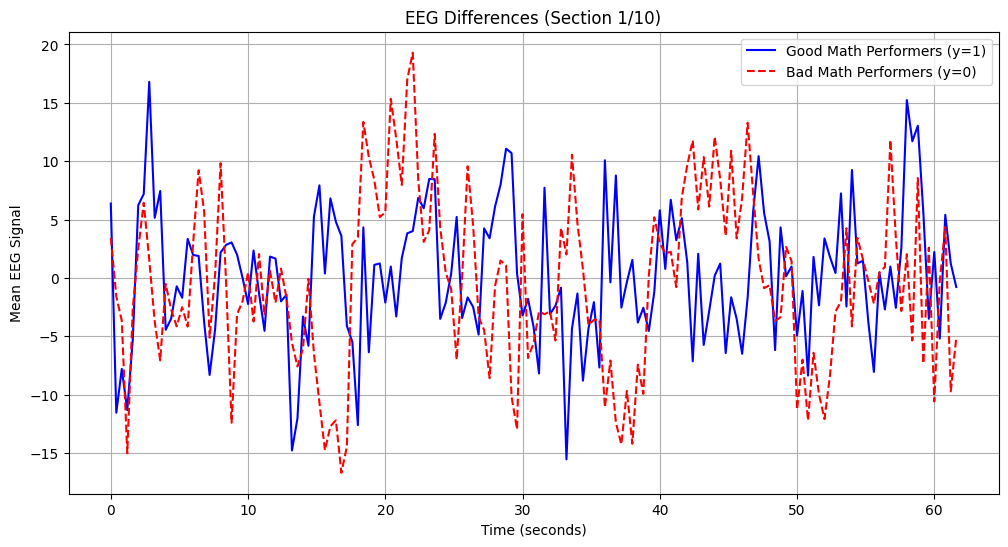

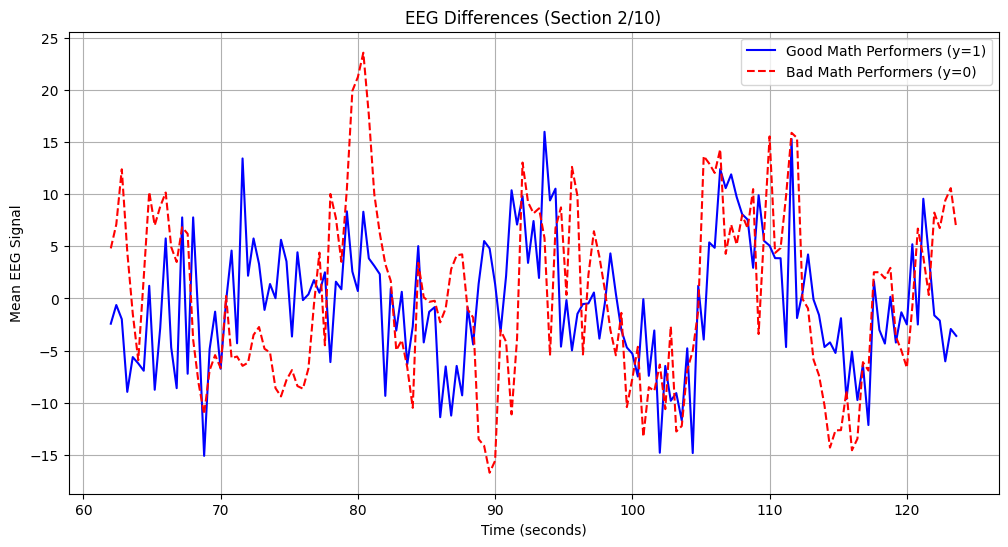

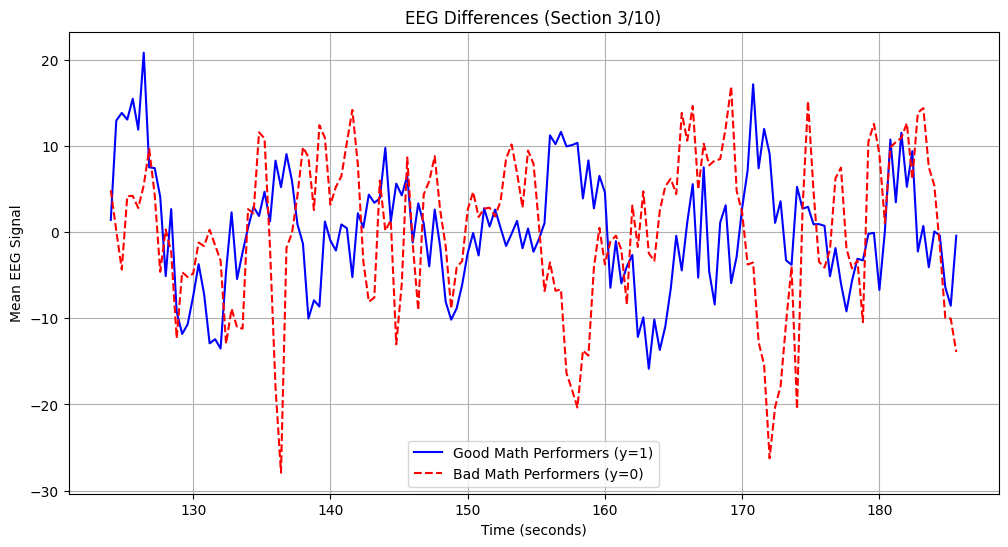

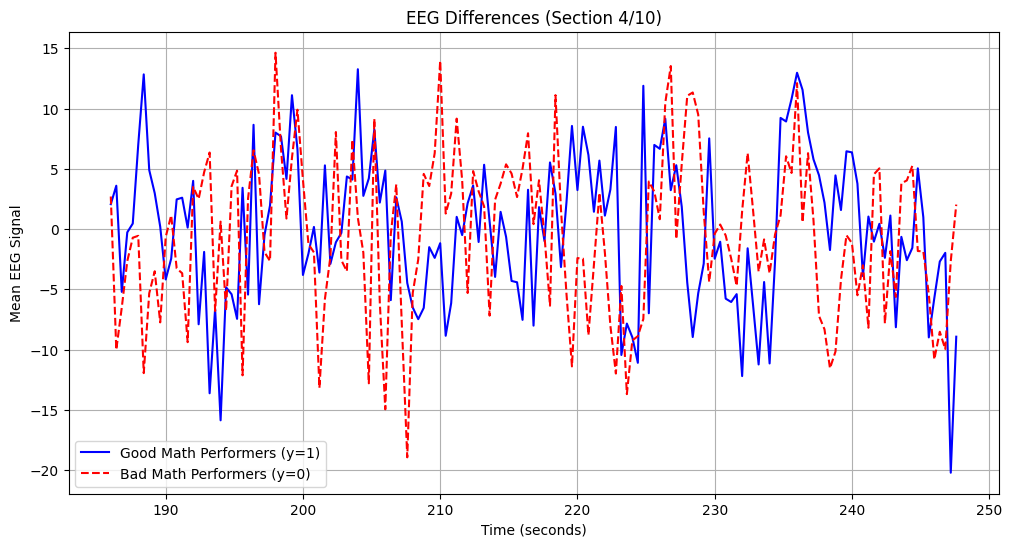

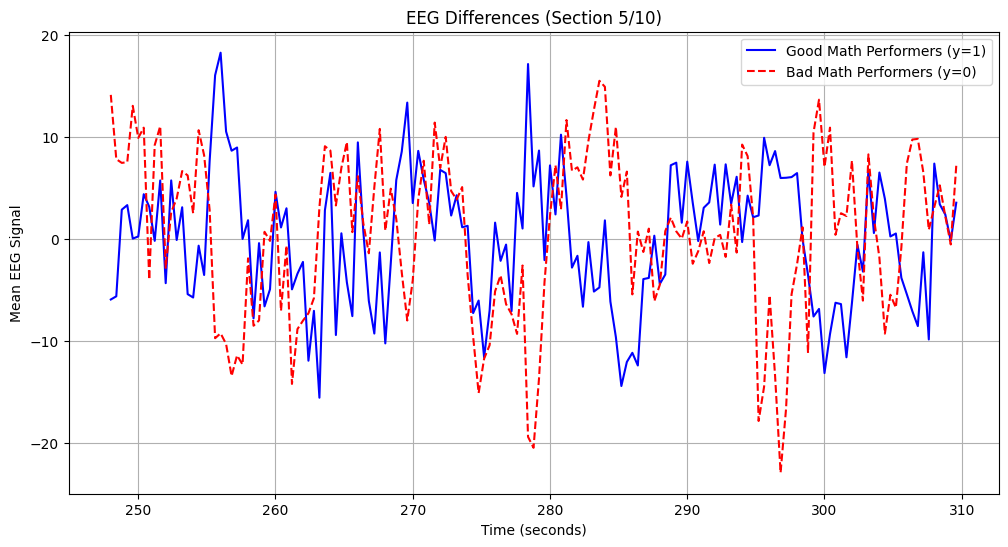

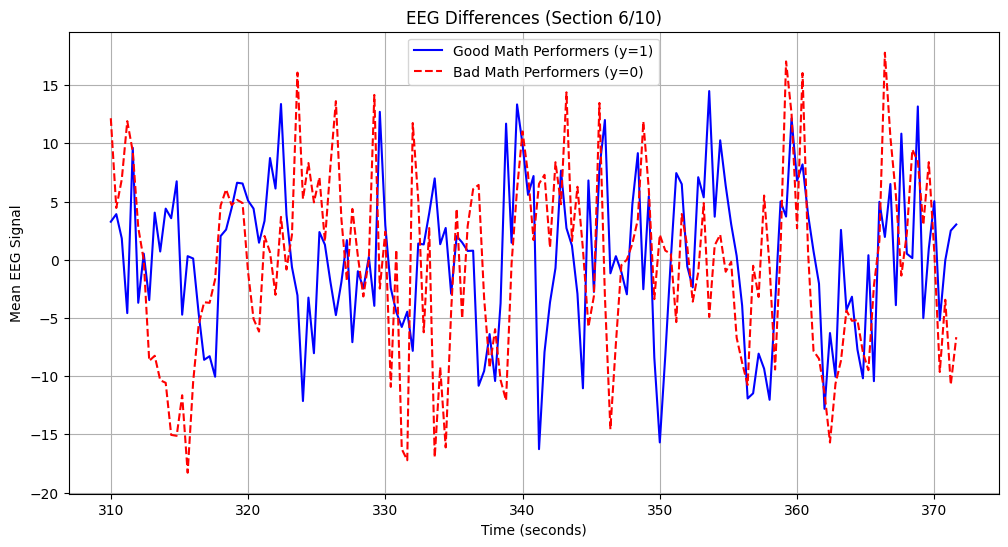

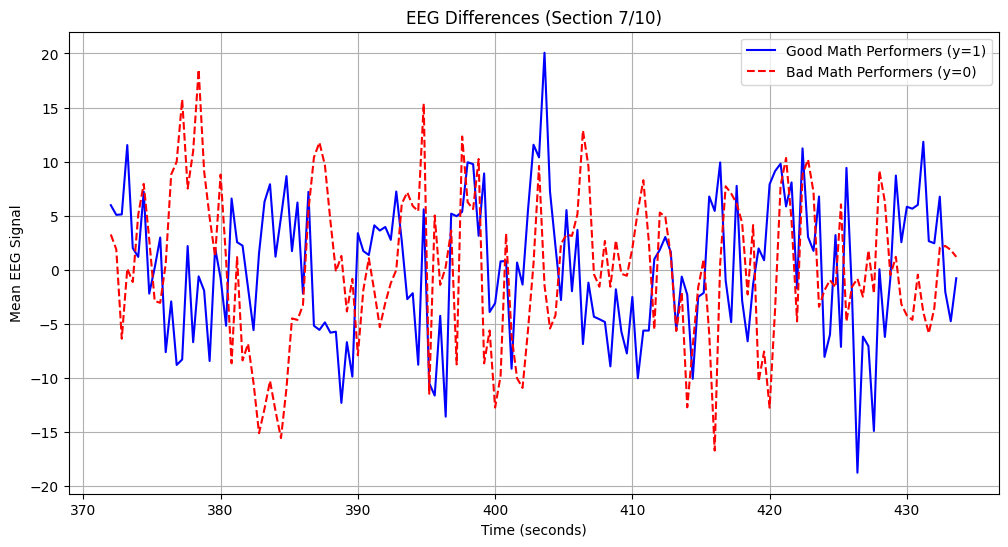

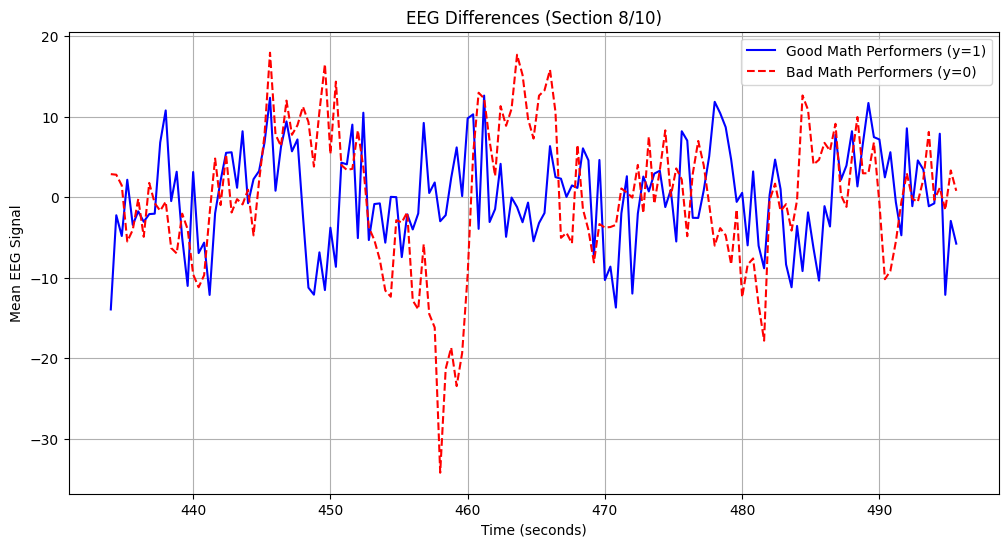

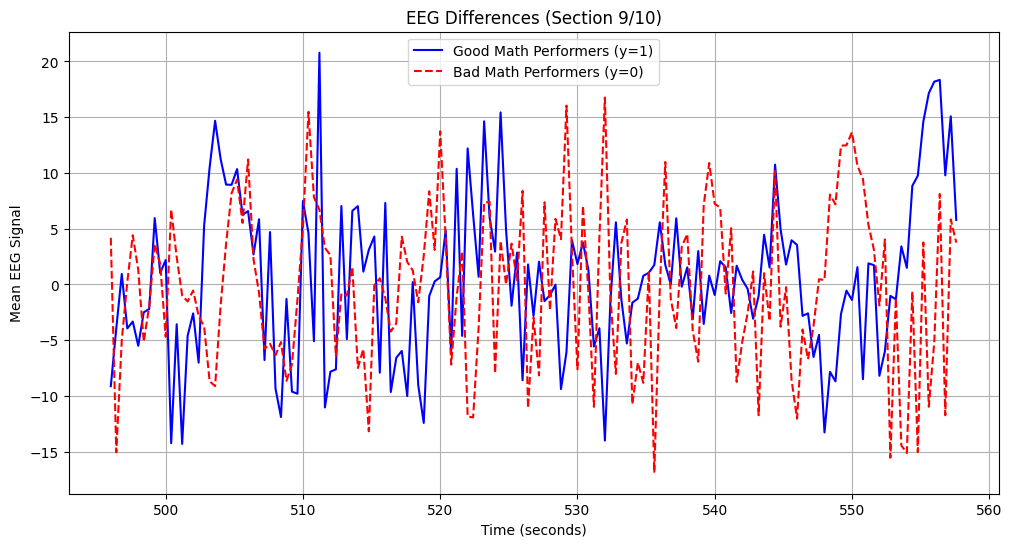

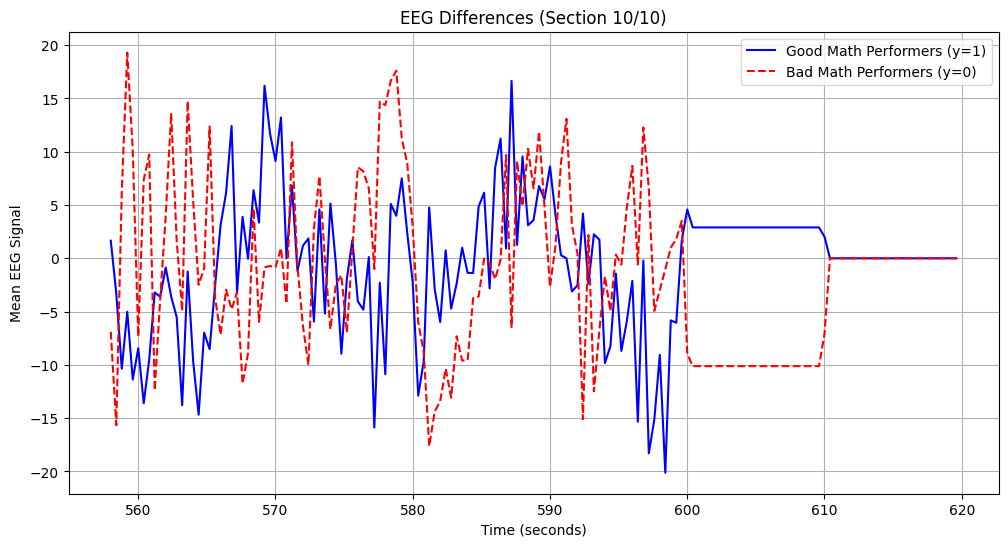

In [35]:
# Loop through and plot separately
for i in range(num_splits):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size

    # Get the current section of EEG data for both groups
    section_good = X_good[:, :, :, start_idx:end_idx]
    section_bad = X_bad[:, :, :, start_idx:end_idx]

    # Compute the mean EEG signal for each group (average over subjects and electrodes)
    mean_good = np.mean(section_good, axis=(0, 2))  # Averaging over subjects & electrodes
    mean_bad = np.mean(section_bad, axis=(0, 2))

    # Compute actual time points
    time_axis = np.arange(start_idx, end_idx) * time_per_sample  # Convert indices to actual time

    # Plot the results
    plt.figure(figsize=(12, 6))  # Increase figure size
    plt.plot(time_axis, mean_good[0], label="Good Math Performers (y=1)", color='blue')
    plt.plot(time_axis, mean_bad[0], label="Bad Math Performers (y=0)", color='red', linestyle='dashed')

    plt.xlabel("Time (seconds)")
    plt.ylabel("Mean EEG Signal")
    plt.title(f"EEG Differences (Section {i+1}/{num_splits})")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.pause(2)  # Pause before showing the next plot

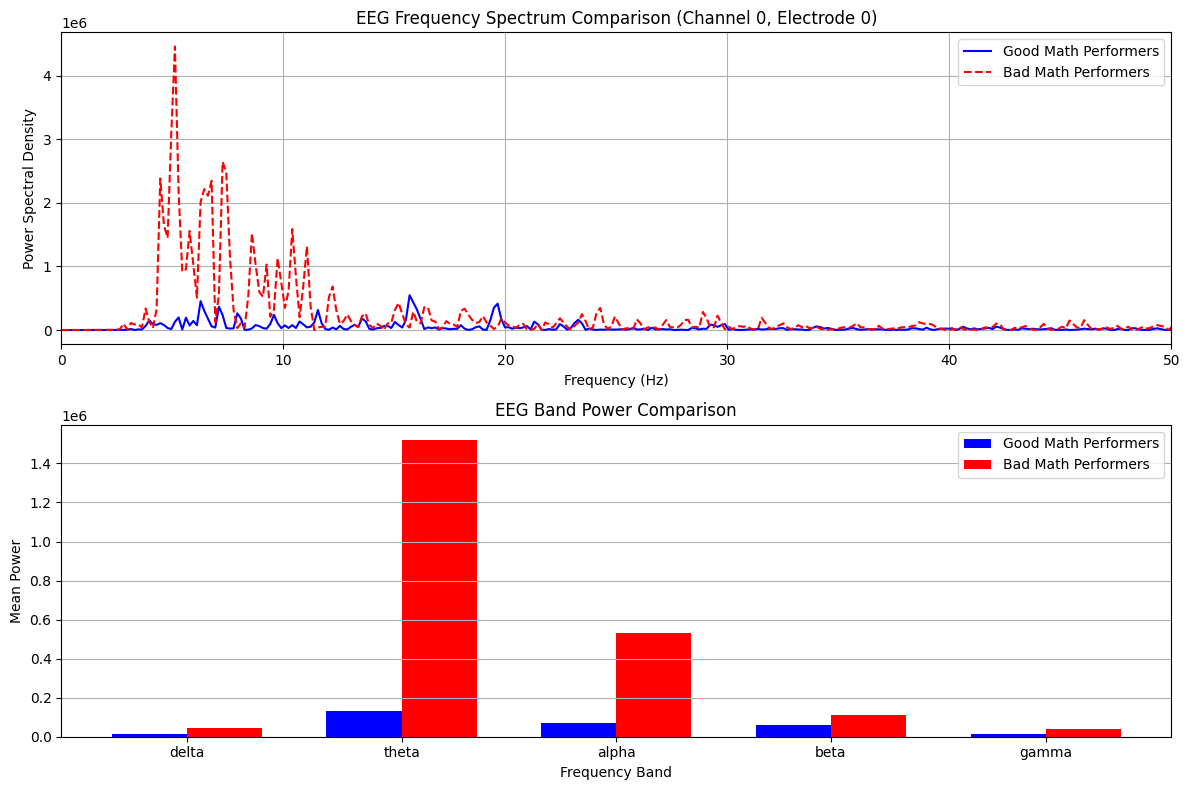

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def apply_fft_to_eeg_groups(X_good, X_bad, sampling_rate, window_length=None):
    """
    Apply FFT to EEG data from two groups and compare frequency spectra
    
    Parameters:
    -----------
    X_good : array
        EEG data for good performers (subjects, channels, electrodes, time_points)
    X_bad : array
        EEG data for bad performers (subjects, channels, electrodes, time_points)
    sampling_rate : float
        Sampling rate in Hz
    window_length : int, optional
        Length of window to use (if None, use entire signal)
        
    Returns:
    --------
    freqs : array
        Frequency bins
    psd_good : array
        Power spectrum for good performers
    psd_bad : array
        Power spectrum for bad performers
    """
    # Get shapes
    n_subjects_good, n_channels, n_electrodes, n_timepoints = X_good.shape
    n_subjects_bad = X_bad.shape[0]
    
    # Use entire signal length if window not specified
    if window_length is None:
        window_length = n_timepoints
    
    # Initialize arrays to store power spectra
    freqs = np.fft.rfftfreq(window_length, d=1.0/sampling_rate)
    psd_good = np.zeros((n_channels, n_electrodes, len(freqs)))
    psd_bad = np.zeros((n_channels, n_electrodes, len(freqs)))
    
    # Calculate FFT for good performers
    for subj in range(n_subjects_good):
        for ch in range(n_channels):
            for elec in range(n_electrodes):
                signal_good = X_good[subj, ch, elec, :window_length]
                # Apply Hanning window to reduce spectral leakage
                windowed_signal = signal_good * np.hanning(len(signal_good))
                # Calculate FFT
                fft_result = np.fft.rfft(windowed_signal)
                # Power spectrum
                power = np.abs(fft_result)**2
                psd_good[ch, elec] += power
    
    # Average across subjects
    psd_good /= n_subjects_good
    
    # Calculate FFT for bad performers
    for subj in range(n_subjects_bad):
        for ch in range(n_channels):
            for elec in range(n_electrodes):
                signal_bad = X_bad[subj, ch, elec, :window_length]
                # Apply Hanning window
                windowed_signal = signal_bad * np.hanning(len(signal_bad))
                # Calculate FFT
                fft_result = np.fft.rfft(windowed_signal)
                # Power spectrum
                power = np.abs(fft_result)**2
                psd_bad[ch, elec] += power
    
    # Average across subjects
    psd_bad /= n_subjects_bad
    
    return freqs, psd_good, psd_bad

def plot_frequency_comparison(freqs, psd_good, psd_bad, channel=0, electrode=0, 
                             freq_range=(0, 50), band_names=None):
    """
    Plot frequency comparison between good and bad performers
    """
    plt.figure(figsize=(12, 8))
    
    # Plot overall spectrum
    plt.subplot(2, 1, 1)
    plt.plot(freqs, psd_good[channel, electrode], label="Good Math Performers", color='blue')
    plt.plot(freqs, psd_bad[channel, electrode], label="Bad Math Performers", color='red', linestyle='dashed')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.title(f"EEG Frequency Spectrum Comparison (Channel {channel}, Electrode {electrode})")
    plt.xlim(freq_range)
    plt.legend()
    plt.grid(True)
    
    # Plot band powers if specified
    if band_names is not None:
        bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 50)
        }
        
        # Calculate band powers
        band_powers_good = []
        band_powers_bad = []
        band_labels = []
        
        for band, (low_freq, high_freq) in bands.items():
            if band in band_names:
                # Find indices for this frequency band
                band_idx = np.where((freqs >= low_freq) & (freqs <= high_freq))[0]
                # Calculate mean power in band
                power_good = np.mean(psd_good[channel, electrode, band_idx])
                power_bad = np.mean(psd_bad[channel, electrode, band_idx])
                band_powers_good.append(power_good)
                band_powers_bad.append(power_bad)
                band_labels.append(band)
        
        # Plot band powers
        plt.subplot(2, 1, 2)
        x = np.arange(len(band_labels))
        width = 0.35
        plt.bar(x - width/2, band_powers_good, width, label="Good Math Performers", color='blue')
        plt.bar(x + width/2, band_powers_bad, width, label="Bad Math Performers", color='red')
        plt.xlabel("Frequency Band")
        plt.ylabel("Mean Power")
        plt.title("EEG Band Power Comparison")
        plt.xticks(x, band_labels)
        plt.legend()
        plt.grid(True, axis='y')
    
    plt.tight_layout()
    plt.show()

# Example usage (you'll need to fill in the actual values)
sampling_rate = 256  # Replace with your actual sampling rate
freqs, psd_good, psd_bad = apply_fft_to_eeg_groups(X_good, X_bad, sampling_rate)

# Plot results for a specific channel and electrode
plot_frequency_comparison(freqs, psd_good, psd_bad, channel=0, electrode=0, 
                         band_names=['delta', 'theta', 'alpha', 'beta', 'gamma'])